SCHEDULING O(M*J*T)

In [ ]:
import numpy as np
from qiskit.quantum_info import SparsePauliOp
from itertools import product
import networkx as nx
import matplotlib.pyplot as plt


# Define identity and Z matrices as Pauli strings
Z = 'Z'
I = 'I'

# Function to generate SparsePauliOp
def kronecker_product(operators, coeff, N):
    # Construct the Pauli string by joining the operators
    pauli_string = ''.join(operators)

    # Create the SparsePauliOp with the given coefficient
    return SparsePauliOp.from_list([(pauli_string, coeff)], num_qubits=N)

#Function to access the qubit from its m,j,t index
#@params
# @@@ m - machine index
# @@@ j - job index
# @@@ t - time index
def get_indicator_index(m, j, t, M, J):
    return m + M * j + M * J * t

def H_no_parallel_execution(M, J, T, run_times, penalty_coeff):
    J = J + 1 #Adding the dummy node
    T = T + 1 #Adding time for dummy job
    num_qubits = M * J * T
    term = SparsePauliOp.from_list([], num_qubits=num_qubits)

    #Loop through all combinations that need Z:
    for m in range(M):
        for j in range(J):
            for j_tag in range(j+1, J): #Pairs
                for t in range(T):
                    for t_tag in range(0, min(t + run_times[j], T)): #Note - it is not run_times[j] - 1, since range doesn't include the edge 
                        #Adding each element for the eigenvalue
                        operators = [I for i in range(num_qubits)]
                        operators[get_indicator_index(m,j,t, M, J)] = Z
                        term += kronecker_product(operators, -1 * penalty_coeff, num_qubits)
                        #print(f"H_no_parallel: (m, j, t)=({m}, {j}, {t}), (m,j',t')=({m},{j_tag},{t_tag})")
                        operators = [I for i in range(num_qubits)]
                        operators[get_indicator_index(m,j_tag,t_tag, M, J)] = Z
                        term += kronecker_product(operators, -1 * penalty_coeff, num_qubits)
                        
                        operators = [I for i in range(num_qubits)]
                        operators[get_indicator_index(m,j,t, M, J)] = Z
                        operators[get_indicator_index(m,j_tag,t_tag, M, J)] = Z
                        term += kronecker_product(operators, penalty_coeff, num_qubits)

    return term

def H_dependency(M, J, T, E, run_times, penalty_coeff):
    J = J + 1 #Adding the dummy node
    T = T + 1 #Adding time for dummy job
    num_qubits = M * J * T

    #The last j is the dummy job
    run_times = run_times + [0]
    E += [(i, J-1) for i in range(J-1)] #Adding edges from the jobs to the dummy
    #print(f"E: {E}")
    ###
    term = SparsePauliOp.from_list([], num_qubits=num_qubits)

    #initialized as all Identity
    operators = [I for i in range(num_qubits)]

    #Loop through all combinations that need Z:
    for (j,j_tag) in E:
        for m in range(M):
            for m_tag in range(M):
                for t in range(T):
                    for t_tag in range(0, min(t + run_times[j], T)): #Note - run_times[j] - 1 
                        #Adding each element for the eigenvalue
                        operators = [I for i in range(num_qubits)]
                        operators[get_indicator_index(m,j,t, M, J)] = Z
                        term += kronecker_product(operators, -1 * penalty_coeff, num_qubits)
                        #print(f"H_dep: (m, j, t)=({m}, {j}, {t}), (m',j',t')=({m},{j_tag},{t_tag})")
                        operators = [I for i in range(num_qubits)]
                        operators[get_indicator_index(m_tag,j_tag,t_tag, M, J)] = Z
                        term += kronecker_product(operators, -1 * penalty_coeff, num_qubits)
                        
                        operators = [I for i in range(num_qubits)]
                        operators[get_indicator_index(m,j,t, M, J)] = Z
                        operators[get_indicator_index(m_tag,j_tag,t_tag, M, J)] = Z
                        term += kronecker_product(operators, penalty_coeff, num_qubits)

    return term

def H_force_run(M, J, T, penalty_coeff): #Force every job to run once.
    J = J + 1 #Adding the dummy node
    T = T + 1 #Adding time for dummy job
    num_qubits = M * J * T

    ###
    term = SparsePauliOp.from_list([], num_qubits=num_qubits)

    #initialized as all Identity
    operators = [I for i in range(num_qubits)]

    for j in range(J):
        #Loop through all combinations that need Z:
        for m in range(M):
            for t in range(T):
                operators = [I for i in range(num_qubits)]
                operators[get_indicator_index(m,j,t, M, J)] = Z
                term += kronecker_product(operators, (1 - M * T / 2) * penalty_coeff, num_qubits)

        #Loop through all combinations that need Z:
        for m in range(M):
            for m_tag in range(M):
                for t in range(T):
                    for t_tag in range(t+1, T):
                        operators = [I for i in range(num_qubits)]
                        operators[get_indicator_index(m,j,t, M, J)] = Z
                        operators[get_indicator_index(m_tag,j,t_tag, M, J)] = Z
                        term += kronecker_product(operators, 0.5 * penalty_coeff, num_qubits)

    return term

def H_finish_time(M, J, T):
    J = J + 1 #Adding the dummy node
    T = T + 1 #Adding time for dummy job
    num_qubits = M * J * T
    #The last j is the dummy job
    term = SparsePauliOp.from_list([], num_qubits=num_qubits)

    #initialized as all Identity
    operators = [I for i in range(num_qubits)]

    #Loop through all combinations that need Z:
    j_dummy = J - 1

    #Score for adding the dummy job on any machine
    for t in range(T):
        for m in range(M):
                operators = [I for i in range(num_qubits)]
                operators[get_indicator_index(m,j_dummy,t, M, J)] = Z
                term += kronecker_product(operators, (-1) * t, num_qubits)

    return term

# Define a sample problem
#Note, the last job is the dummy job
#M = 2
#J = 3
#E = [(0, 2), (1,2)]
#run_times = np.array([1,2,1])

#### TEST 0 - 4 qubits PASSED
M = 1
J = 1
E = []
run_times = np.array([1])
####

#### TEST 1 - 9 qubits PASSED
M = 1
J = 2
E = [(0,1)]
run_times = np.array([1,1])
####

#### TEST 1 - 18 qubits ???
M = 2
J = 2
E = [(0,1)]
run_times = np.array([1,1])
####

penalty_coeff = 100

#Naive Upper bound on T:
T = np.sum(run_times)
num_qubits = M*(J+1)*(T+1)

print(f"Used {num_qubits} qubits")

# Calculate each Hamiltonian term
H_no_parallel = H_no_parallel_execution(M, J, T, run_times, penalty_coeff)
H_dependency = H_dependency(M, J, T, E, run_times, penalty_coeff)
H_dummy = H_force_run(M, J, T, penalty_coeff)
H_finish_time = H_finish_time(M, J, T)

# Sum up to get the total Hamiltonian
H_total_JSP = H_no_parallel + H_dependency + H_finish_time + H_dummy

/home/uni_x/.local/lib/python3.10/site-packages/numpy/_core/getlimits.py:551: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


Used 9 qubits


In [2]:
import numpy as np

def vector_to_quantum_state(vector):
    # Find the index of the non-zero element
    index = np.argmax(vector)
    
    # Convert the index to binary representation
    n = int(np.log2(len(vector)))  # Calculate the number of qubits
    binary_representation = format(index, f'0{n}b')  # Format index as binary with leading zeros
    
    # Create the quantum state string
    quantum_state = '|' + ''.join(binary_representation) + '>'
    
    return quantum_state

import itertools
def generate_binary_vectors(n):
    for vector in itertools.product([0, 1], repeat=n): #of Z eigenvalues
        yield np.array(vector)

def generate_one_hot_vectors(n):
    for i in range(n):
        vector = [0] * n  # Create a vector of zeros
        vector[i] = 1     # Set the i-th position to 1
        yield np.array(vector).reshape((n, 1)) # Yield the one-hot vector


In [ ]:
#from scipy.linalg import eigh

#Convert SparsePauliOp to a dense matrix
H_matrix = H_total_JSP.to_matrix()
print(f"H_matrix shape: {H_matrix.shape}")

min_eigenvalue = float("inf")
min_eigenvector = None

for eigenvector in generate_one_hot_vectors(2**num_qubits):
    new_eigenvalue = eigenvector.T @ H_matrix @ eigenvector
    
    #print(new_eigenvalue)
    
    #Find minimal eigenvalue
    if(new_eigenvalue < min_eigenvalue):
        min_eigenvalue = new_eigenvalue[0,0]
        min_eigenvector = eigenvector


#Actual diagonalization
'''
#Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = eigh(H_matrix)

#Find the minimum eigenvalue and corresponding eigenvector
min_eigenvalue = np.min(eigenvalues)
min_eigenvector = eigenvectors[:, np.argmin(eigenvalues)]
'''

print("Minimum Eigenvalue:", min_eigenvalue.real)
#print("Corresponding Eigenvector:", min_eigenvector.T)
print("Quantum State (computational basis):", vector_to_quantum_state(min_eigenvector))

H_matrix shape: (512, 512)
Minimum Eigenvalue: -3899.0
Corresponding Eigenvector: [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [2]:
# from qiskit_algorithms import NumPyMinimumEigensolver
# def get_exact_ground(hamiltonian):
#     # Instantiate the NumPy classical solver

#     eigensolver = NumPyMinimumEigensolver()

#     # Compute the result using the eigensolver on the Hamiltonian
#     result = eigensolver.compute_minimum_eigenvalue(operator=hamiltonian)

#     # Extract the eigenvalue and eigenstate
#     eigenvalue = result.eigenvalue

#     return eigenvalue

# print(get_exact_ground(H_total_JSP))

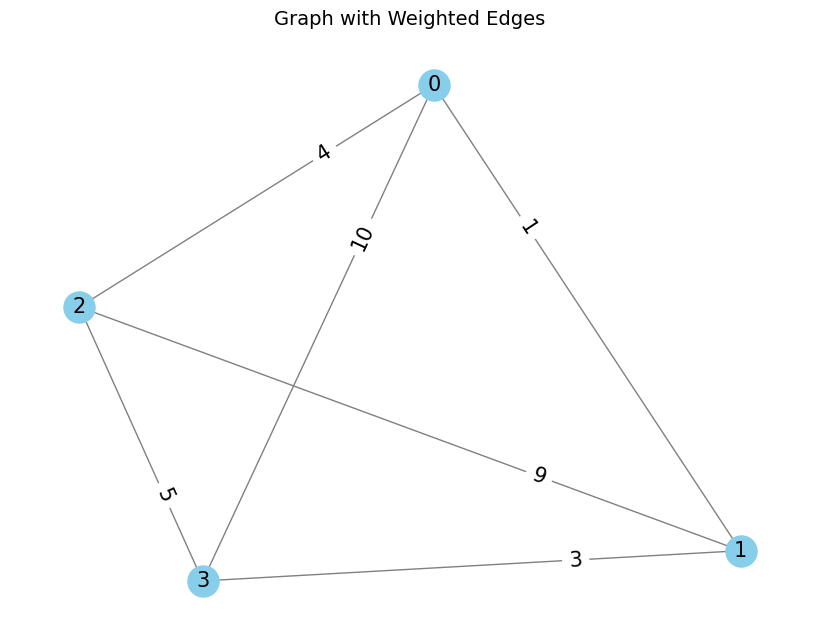

: 

In [ ]:
E = [(0, 1), (0, 3),(0,2), (1, 2),(1,3), (2, 3)]
W = {(0, 1): 1,(0, 3): 10, (1, 2): 9, (2, 3): 5,(0,2):4,(1,3):3}

# Initialize the graph and add your custom edges and weights
G = nx.Graph()
G.add_edges_from(E)
nx.set_edge_attributes(G, W, 'weight')

# Use a spring layout to spread nodes out more evenly
pos = nx.spring_layout(G, seed=42)  # Seed for reproducibility

# Plot the graph with the improved layout
plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=True, node_color="skyblue", edge_color="gray", node_size=500, font_size=15)

# Get the edge labels (weights) and draw them with small offsets
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=15, label_pos=0.3)

plt.title("Graph with Weighted Edges", fontsize=14)
plt.show()

# Print the graph's edges with weights
#print("Graph edges with weights:")
#for edge in G.edges(data=True):
#    print(edge)
#print(get_exact_ground(H_total_TSP))


In [ ]:

vector_to_quantum_state([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
from ipynb.fs.full.ansatz import get_twolocal
from qiskit.quantum_info import SparsePauliOp
import networkx as nx
import random

from hamiltonians import gen_trans_ising_op, get_exact_ground, gen_maxcut_op, gen_maxcut_op_from_graph
from experiment_utils import *

random.seed(5)
TSP_landscape = run_and_record_landscape(H_total_TSP_full_graph, n_mub_qubits=3, desc="TSP Hamiltonian full graph, 9 qubits")

In [ ]:
E = [(0, 1), (0, 3), (1, 2), (2, 3)]
W = {(0, 1): 1,(0, 3): 10, (1, 2): 9, (2, 3): 5}

# Initialize the graph and add your custom edges and weights
G = nx.Graph()
G.add_edges_from(E)
nx.set_edge_attributes(G, W, 'weight')

# Use a spring layout to spread nodes out more evenly
pos = nx.spring_layout(G, seed=42)  # Seed for reproducibility

# Plot the graph with the improved layout
plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=True, node_color="skyblue", edge_color="gray", node_size=500, font_size=15)

# Get the edge labels (weights) and draw them with small offsets
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=15, label_pos=0.3)

plt.title("Graph with Weighted Edges", fontsize=14)
plt.show()

# Print the graph's edges with weights
#print("Graph edges with weights:")
#for edge in G.edges(data=True):
#    print(edge)
#print(get_exact_ground(H_total_TSP))


In [ ]:
N = 4
num_qubits=(N-1)**2
# the weights and edges writing should be (i,j) such that i<j !!
# ensure N coreesponds the right number of vertices in E,W
E = [(0, 1), (0, 3), (1, 2), (2, 3)]
W = {(0, 1): 1,(0, 3): 10, (1, 2): 9, (2, 3): 5}
A = max(W.values())*len(E)


# Calculate each Hamiltonian term
H_verices_term_p = H_vertices_TSP(num_qubits,N,A)
H_time_term_p = H_time_TSP(num_qubits,N,A)
H_pen_term_p=H_pen_TSP(num_qubits,N,A,E)
H_pen_depot_term_p=H_Pen_depot_TSP(num_qubits,N,A,E)
H_weight_term_p=H_weight_TSP(num_qubits,N,A,E,W)
H_Weight_depot_term_p=H_Weight_depot_TSP(num_qubits,N,A,E,W)

# Sum up to get the total Hamiltonian
H_total_TSP_partial_graph = H_verices_term_p + H_time_term_p + H_pen_term_p + H_pen_depot_term_p + H_weight_term_p +H_Weight_depot_term_p


random.seed(5)
TSP_landscape_partial = run_and_record_landscape(H_total_TSP_partial_graph, n_mub_qubits=3, desc="TSP Hamiltonian -not full graph, 9 qubits")


In [ ]:
#####################################################################################


VRP HAMILTONIAN

VRP With N(N+k-1) qubits - not relevant anymore!

In [ ]:
# #VRP With N(N+k-1) qubits - use it if the other version give weird results.
# import numpy as np
# from qiskit.quantum_info import SparsePauliOp
# from itertools import product
# import networkx as nx
# import matplotlib.pyplot as plt

# # Define identity and Z matrices as Pauli strings
# Z = 'Z'
# I = 'I'

# # Function to generate SparsePauliOp
# def kronecker_product(operators, coeff, N):
#     # Construct the Pauli string by joining the operators
#     pauli_string = ''.join(operators)

#     # Create the SparsePauliOp with the given coefficient
#     return SparsePauliOp.from_list([(pauli_string, coeff)],num_qubits=N)
# def H_start(num_qubits, A):
#     # Start with the identity term (coefficient times identity)
#     identity_term = SparsePauliOp.from_list([('I' * num_qubits, A/2)])
#     term = SparsePauliOp.from_list([],num_qubits=num_qubits)
#     operators = [I if (i != 0) else Z for i in range(num_qubits)]
#     term += kronecker_product(operators, A / 2,num_qubits)
#     return identity_term + term
# def H_B(num_qubits,A,k,T,N_t):
#     # Start with the identity term (coefficient times identity)
#     identity_term = SparsePauliOp.from_list([('I' * num_qubits, A*(k**2-k*T+(T**2)/4))],num_qubits=num_qubits)

#     term2 = SparsePauliOp.from_list([],num_qubits=num_qubits)
#     for j in range(0,T):
#         operators = [I if (i != 0 * T + j) else Z for i in range(num_qubits)]
#         term2 += kronecker_product(operators, (A/2)*(2*k-T) , num_qubits)

#     term3 = SparsePauliOp.from_list([],num_qubits=num_qubits)
#     for j in range(0,T):
#         for i in range(0,T):
#             operators = [I if (j == i) else I if(l != 0 * T + j and l != 0 * T + i) else Z for l in range(num_qubits)]
#             term3 += kronecker_product(operators, A / 4, num_qubits)

#     return identity_term + term2 + term3
# def H_C(num_qubits,N, A,k,T,N_t):
#     # Start with the identity term (coefficient times identity)
#     identity_term = SparsePauliOp.from_list([('I' * num_qubits, A * (N-1) * (1- T + (T**2) / 4))],num_qubits=num_qubits)

#     term2 = SparsePauliOp.from_list([],num_qubits=num_qubits)
#     for v in range(1,N):
#         for j in range(0,T):
#             operators = [I if (i != v * T + j) else Z for i in range(num_qubits)]
#             term2 += kronecker_product(operators, A * (2-T) / 2, num_qubits)

#     term3 = SparsePauliOp.from_list([],num_qubits=num_qubits)
#     for v in range(1,N):
#         for j in range(0,T):
#             for i in range(0,T):
#                 operators = [I if (j == i) else I if(l != v * T + j and l != v * T + i) else Z for l in range(num_qubits)]
#                 term3 += kronecker_product(operators, A / 4, num_qubits)

#     return identity_term + term2 + term3

# def H_D(num_qubits,N, A,k,T,N_t):
#     identity_term = SparsePauliOp.from_list([('I' * num_qubits, A*T*(1-N+(N**2/4)))],num_qubits=num_qubits)

#     term2 = SparsePauliOp.from_list([],num_qubits=num_qubits)
#     for j in range(0,T):
#         for v in range(0,N):
#             operators = [I if (i != v * T + j) else Z for i in range(num_qubits)]
#             term2 += kronecker_product(operators, A * (2-N) / 2, num_qubits)

#     term3 = SparsePauliOp.from_list([],num_qubits=num_qubits)
#     for j in range(0,T):
#         for v in range(0,N):
#             for u in range(0,N):
#                 operators = [I if ((l != v * T + j and l != u * T + j) or v == u) else Z for l in range(num_qubits)]
#                 term3 += kronecker_product(operators, A / 4, num_qubits)

#     return identity_term + term2 + term3

# def H_E(num_qubits,N, A,k,T,N_t,E):
#     term = SparsePauliOp.from_list([],num_qubits=num_qubits)
#     for u, v in product(range(N), repeat=2):
#         if (u, v) not in E and (v, u) not in E and u != v:
#             for j in range(0,T):
#                 operators = [I] * num_qubits
#                 operators[u * T + j] = Z
#                 operators[v * T + ((j + 1) % T)] = Z
#                 t1 = kronecker_product(operators, 1, num_qubits)

#                 operators = [I] * num_qubits
#                 operators[u * T + j] = Z
#                 t2 = kronecker_product(operators, -1, num_qubits)

#                 operators = [I] * num_qubits
#                 operators[v * T + ((j + 1) % T)] = Z
#                 t3 = kronecker_product(operators, -1, num_qubits)

#                 term += A / 4 * (t1 + t2 + t3 + SparsePauliOp.from_list([('I' * num_qubits, 1)],num_qubits=num_qubits))

#     return term

# def H_F(num_qubits,N, A,k,T,N_t,E,W):
#     term = SparsePauliOp.from_list([],num_qubits=num_qubits)
#     for (u, v) in E:
#         for j in range(0,T):
#             operators = [I] * num_qubits
#             operators[u * T + j] = Z
#             operators[v * T + ((j + 1) % T)] = Z
#             t1 = kronecker_product(operators, W[(u, v)], num_qubits)

#             operators = [I] * num_qubits
#             operators[u * T + j] = Z
#             t2 = kronecker_product(operators, -W[(u, v)], num_qubits)

#             operators = [I] * num_qubits
#             operators[v * T + ((j + 1) % T)] = Z
#             t3 = kronecker_product(operators, -W[(u, v)], num_qubits)

#             term += (t1 + t2 + t3 + SparsePauliOp.from_list([('I' * num_qubits, W[(u, v)])],num_qubits=num_qubits)) / 4

#     for (u, v) in E:
#         for j in range(0,T):
#             operators = [I] * num_qubits
#             operators[v * T + j] = Z
#             operators[u * T + ((j + 1) % T)] = Z
#             t1 = kronecker_product(operators, W[(u, v)], num_qubits)

#             operators = [I] * num_qubits
#             operators[v * T + j] = Z
#             t2 = kronecker_product(operators, -W[(u, v)], num_qubits)

#             operators = [I] * num_qubits
#             operators[u * T + ((j + 1) % T)] = Z
#             t3 = kronecker_product(operators, -W[(u, v)], num_qubits)

#             term += (t1 + t2 + t3 + SparsePauliOp.from_list([('I' * num_qubits, W[(u, v)])],num_qubits=num_qubits)) / 4

#     return term

# # Define a sample graph
# N = 4  # Number of vertices (including depot)
# k = 1    # Number of vehicles
# N_t = k + N
# T = N_t - 1    # T = k + N - 1

# # Define the edges and weights
# #E = [(0, 1), (0, 2), (1, 2)]
# #W = {(0, 1): 10, (1, 2): 15, (0,2) :3}
# # Define edges of the graph

# # the weights and edges writing should be (i,j) such that i<j !!
# # ensure N coreesponds the right number of vertices in E,W
# E = [(0, 1), (1, 3), (0, 3), (1, 2), (0, 2), (2, 3)]

# # Define the corresponding weights for the edges
# W = {(0, 1): 2, (1, 2): 3, (0, 2): 4, (0, 3): 3, (1, 3): 1, (2, 3): 5}

# A=max(W.values())*len(E)+1
# num_qubits=N*T


# # Calculate each Hamiltonian term
# H_start_term = H_start(num_qubits,A)
# H_B_term = H_B(num_qubits,A,k,T,N_t)
# H_C_term = H_C(num_qubits,N,A,k,T,N_t)
# H_D_term = H_D(num_qubits,N,A,k,T,N_t)
# H_E_term = H_E(num_qubits,N,A,k,T,N_t,E)
# H_F_term = H_F(num_qubits,N,A,k,T,N_t,E,W)

# # Sum up to get the total Hamiltonian
# H_total = H_start_term + H_B_term + H_C_term + H_D_term +H_E_term+H_F_term

In [ ]:
# def draw_graph(E, W):
#     G = nx.Graph()
#     G.add_edges_from(E)

#     pos = nx.spring_layout(G)  # positions for all nodes
#     labels = {}

#     # Add edge weights, accounting for both (u, v) and (v, u) keys in the weight dictionary
#     for edge in G.edges:
#         if edge in W:
#             labels[edge] = W[edge]
#         elif (edge[1], edge[0]) in W:  # Check the reverse of the edge
#             labels[edge] = W[(edge[1], edge[0])]

#     nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, font_weight='bold')
#     nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

#     plt.title("Graph Representation of the Problem")
#     plt.show()
# draw_graph(E,W)



In [ ]:
# import numpy as np
# from qiskit.quantum_info import SparsePauliOp

# # Function to compute all eigenvectors corresponding to the minimum eigenvalue
# def compute_all_minimum_eigenvectors(H_total, num_qubits):
#     # Convert SparsePauliOp to matrix
#     H_matrix = H_total.to_matrix()

#     # Perform eigenvalue decomposition
#     eigenvalues, eigenvectors = np.linalg.eigh(H_matrix)

#     # Find the minimum eigenvalue
#     min_eigenvalue = np.min(eigenvalues)

#     # Find all eigenvectors corresponding to the minimum eigenvalue
#     min_eigenvalue_indices = np.where(np.isclose(eigenvalues, min_eigenvalue))[0]
#     min_eigenvectors = eigenvectors[:, min_eigenvalue_indices]

#     return min_eigenvalue, min_eigenvectors

# # Function to extract the path from a binary state vector
# def extract_route_from_statevector(binary_state, N, T):
#     # Initialize the route
#     route = []

#     # Iterate over timesteps (T)
#     for t in range(T):
#         # For each timestep, check which vertex is visited
#         for v in range(N):
#             # Each vertex has T bits in the state vector
#             if binary_state[v * T + t] == '1':  # Check if the bit is '1'
#                 route.append(v)
#                 break

#     # Always return to the depot (vertex 0) at the end
#     if route[-1] != 0:
#         route.append(0)

#     return route

# # Function to split the route into separate vehicle paths
# def split_route_for_vehicles(route):
#     vehicles = []
#     current_vehicle = []

#     # Iterate over the route and split at every return to vertex 0 (except the first occurrence)
#     for vertex in route:
#         current_vehicle.append(vertex)
#         if vertex == 0 and len(current_vehicle) > 1:
#             vehicles.append(current_vehicle)
#             current_vehicle = [0]  # Start a new vehicle's route with 0

#     return vehicles

# # Function to normalize and print all state vectors and their corresponding vehicle routes
# def print_all_minimum_state_vectors_and_paths(min_eigenvectors, min_eigenvalue, num_qubits, N, T):
#     # Get the expected length of the state vector for a system
#     expected_state_vector_length = 2 ** num_qubits

#     # Loop over all minimum eigenvectors
#     for idx, min_eigenvector in enumerate(min_eigenvectors.T):
#         # Reduce the eigenvector to the expected length (if larger)
#         min_eigenvector_reduced = min_eigenvector[:expected_state_vector_length]

#         # Normalize the state vector
#         norm_min_eigenvector_reduced = min_eigenvector_reduced / np.linalg.norm(min_eigenvector_reduced)

#         # Find the computational basis states with significant amplitudes
#         significant_indices = np.where(np.abs(norm_min_eigenvector_reduced) > 1e-6)[0]  # Threshold for significant amplitudes

#         # Get the binary representations of these states
#         binary_states = [format(index, f'0{num_qubits}b') for index in significant_indices]

#         # Output the minimum eigenvalue and the states
#         print(f"Minimum eigenvalue: {min_eigenvalue}")
#         print(f"Corresponding non-zero computational basis states and amplitudes for eigenvector {idx + 1}:")
#         for index, state in zip(significant_indices, binary_states):
#             amplitude = norm_min_eigenvector_reduced[index]
#             print(f"State: |{state}> with amplitude: {amplitude}")

#             # Extract the path based on the binary state
#             route = extract_route_from_statevector(state, N, T)

#             # Split the route for each vehicle
#             vehicles = split_route_for_vehicles(route)

#             # Print each vehicle's route
#             for vehicle_idx, vehicle_route in enumerate(vehicles, 1):
#                 vehicle_route_str = ' -> '.join(map(str, vehicle_route))
#                 print(f"Vehicle {vehicle_idx}: {vehicle_route_str}")

#         print("\n" + "="*60 + "\n")


# # Compute the minimum eigenvalue and all corresponding eigenvectors
# min_eigenvalue, min_eigenvectors = compute_all_minimum_eigenvectors(H_total, num_qubits)

# # Print the corresponding binary state vectors and amplitudes for a system, along with extracted paths
# print_all_minimum_state_vectors_and_paths(min_eigenvectors, min_eigenvalue, num_qubits, N, T)


VRP Newer version - N(N+k-2) qubits - Relevant version!

In [ ]:
import numpy as np
from qiskit.quantum_info import SparsePauliOp
from itertools import product
import networkx as nx
import matplotlib.pyplot as plt

# Define identity and Z matrices as Pauli strings
Z = 'Z'
I = 'I'

# Function to generate SparsePauliOp
def kronecker_product(operators, coeff, N):
    # Construct the Pauli string by joining the operators
    pauli_string = ''.join(operators)

    # Create the SparsePauliOp with the given coefficient
    return SparsePauliOp.from_list([(pauli_string, coeff)],num_qubits=N)
def H_vehicle_constraint(num_qubits,A,k,T):
    # Start with the identity term (coefficient times identity)
    identity_term = SparsePauliOp.from_list([('I' * num_qubits, A*((k-1)**2-(k-1)*T+(T**2)/4))],num_qubits=num_qubits)

    term2 = SparsePauliOp.from_list([],num_qubits=num_qubits)
    for j in range(0,T):
        operators = [I if (i != 0 * T + j) else Z for i in range(num_qubits)]
        term2 += kronecker_product(operators, (A/2)*(2*(k-1)-T) , num_qubits)

    term3 = SparsePauliOp.from_list([],num_qubits=num_qubits)
    for j in range(0,T):
        for i in range(0,T):
            operators = [I if (j == i) else I if(l != 0 * T + j and l != 0 * T + i) else Z for l in range(num_qubits)]
            term3 += kronecker_product(operators, A / 4, num_qubits)

    return identity_term + term2 + term3
def H_vertices_constraint(num_qubits,N, A,T):
    # Start with the identity term (coefficient times identity)
    identity_term = SparsePauliOp.from_list([('I' * num_qubits, A * (N-1) * (1- T + (T**2) / 4))],num_qubits=num_qubits)

    term2 = SparsePauliOp.from_list([],num_qubits=num_qubits)
    for v in range(1,N):
        for j in range(0,T):
            operators = [I if (i != v * T + j) else Z for i in range(num_qubits)]
            term2 += kronecker_product(operators, A * (2-T) / 2, num_qubits)

    term3 = SparsePauliOp.from_list([],num_qubits=num_qubits)
    for v in range(1,N):
        for j in range(0,T):
            for i in range(0,T):
                operators = [I if (j == i) else I if(l != v * T + j and l != v * T + i) else Z for l in range(num_qubits)]
                term3 += kronecker_product(operators, A / 4, num_qubits)

    return identity_term + term2 + term3

def H_time_constraint(num_qubits,N, A,T):
    identity_term = SparsePauliOp.from_list([('I' * num_qubits, A*T*(1-N+(N**2/4)))],num_qubits=num_qubits)

    term2 = SparsePauliOp.from_list([],num_qubits=num_qubits)
    for j in range(0,T):
        for v in range(0,N):
            operators = [I if (i != v * T + j) else Z for i in range(num_qubits)]
            term2 += kronecker_product(operators, A * (2-N) / 2, num_qubits)

    term3 = SparsePauliOp.from_list([],num_qubits=num_qubits)
    for j in range(0,T):
        for v in range(0,N):
            for u in range(0,N):
                operators = [I if ((l != v * T + j and l != u * T + j) or v == u) else Z for l in range(num_qubits)]
                term3 += kronecker_product(operators, A / 4, num_qubits)

    return identity_term + term2 + term3

def H_edges_constraint(num_qubits,N, A,T,E):
    term = SparsePauliOp.from_list([],num_qubits=num_qubits)
    for u, v in product(range(N), repeat=2):
        if (u, v) not in E and (v, u) not in E and u != v:
            for j in range(0,T-1):
                operators = [I] * num_qubits
                operators[u * T + j] = Z
                operators[v * T + ((j + 1) % T)] = Z
                t1 = kronecker_product(operators, 1, num_qubits)

                operators = [I] * num_qubits
                operators[u * T + j] = Z
                t2 = kronecker_product(operators, -1, num_qubits)

                operators = [I] * num_qubits
                operators[v * T + ((j + 1) % T)] = Z
                t3 = kronecker_product(operators, -1, num_qubits)

                term += A / 4 * (t1 + t2 + t3 + SparsePauliOp.from_list([('I' * num_qubits, 1)],num_qubits=num_qubits))

    return term
def H_depot_edges_constraint(num_qubits,N, A,T,E):
    term = SparsePauliOp.from_list([],num_qubits=num_qubits)
    for v in range(0,N):
        if (0, v) not in E and (v, 0) not in E:
            operators = [I] * num_qubits
            operators[v * T] = Z
            t2 = kronecker_product(operators, -1, num_qubits)

            operators = [I] * num_qubits
            operators[v * T + (T-1)] = Z
            t3 = kronecker_product(operators, -1, num_qubits)

            term += A / 2 * (t2 + t3 + SparsePauliOp.from_list([('I' * num_qubits, 2)],num_qubits=num_qubits))

    return term

def H_weights(num_qubits,T,E,W):
    term = SparsePauliOp.from_list([],num_qubits=num_qubits)
    for (u, v) in E:
        for j in range(0,T-1):
            operators = [I] * num_qubits
            operators[u * T + j] = Z
            operators[v * T + ((j + 1) % T)] = Z
            t1 = kronecker_product(operators, W[(u, v)], num_qubits)

            operators = [I] * num_qubits
            operators[u * T + j] = Z
            t2 = kronecker_product(operators, -W[(u, v)], num_qubits)

            operators = [I] * num_qubits
            operators[v * T + ((j + 1) % T)] = Z
            t3 = kronecker_product(operators, -W[(u, v)], num_qubits)

            term += (t1 + t2 + t3 + SparsePauliOp.from_list([('I' * num_qubits, W[(u, v)])],num_qubits=num_qubits)) / 4

    for (u, v) in E:
        for j in range(0,T-1):
            operators = [I] * num_qubits
            operators[v * T + j] = Z
            operators[u * T + ((j + 1) % T)] = Z
            t1 = kronecker_product(operators, W[(u, v)], num_qubits)

            operators = [I] * num_qubits
            operators[v * T + j] = Z
            t2 = kronecker_product(operators, -W[(u, v)], num_qubits)

            operators = [I] * num_qubits
            operators[u * T + ((j + 1) % T)] = Z
            t3 = kronecker_product(operators, -W[(u, v)], num_qubits)

            term += (t1 + t2 + t3 + SparsePauliOp.from_list([('I' * num_qubits, W[(u, v)])],num_qubits=num_qubits)) / 4

    return term
def H_Weight_depot(num_qubits,T,E,W):
    term = SparsePauliOp.from_list([],num_qubits=num_qubits)
    for (u, v) in E:
        if(u==0):
            operators = [I] * num_qubits
            operators[v * T] = Z
            t2 = kronecker_product(operators, -W[(0, v)], num_qubits)

            operators = [I] * num_qubits
            operators[v * T + T-1] = Z
            t3 = kronecker_product(operators, -W[(0, v)], num_qubits)

            term += (t2 + t3 + SparsePauliOp.from_list([('I' * num_qubits, 2*W[(0, v)])],num_qubits=num_qubits)) / 2

    return term


In [ ]:

# Define a sample graph
N = 4  # Number of vertices (including depot)
k=1
# Number of vehicles

T = k+N-2

# Define the edges and weights
#E = [(0, 1), (0, 2), (1, 2)]
#W = {(0, 1): 10, (1, 2): 15, (0,2) :3}
# Define edges of the graph
# the weights and edges writing should be (i,j) such that i<j !!
# ensure N coreesponds the right number of vertices in E,W
E = [(0, 1),  (0, 3), (1, 2), (2, 3),(1,3),(0,2)]

# Define the corresponding weights for the edges
W = {(0, 1): 1, (1, 2): 9,  (2, 3): 5, (0, 3): 10,(1,3): 3, (0,2): 4}

A=T*max(W.values())+1 # should be > max(W) * (N+k-2)
num_qubits=N*T


# Calculate each Hamiltonian term
h_vehicle_constraint = H_vehicle_constraint(num_qubits,A,k,T)
h_vertices_constraint = H_vertices_constraint(num_qubits,N,A,T)
h_time_constraint = H_time_constraint(num_qubits,N,A,T)
h_edges_constraint = H_edges_constraint(num_qubits,N,A,T,E)
h_weight_term = H_weights(num_qubits,T,E,W)
h_depot_edges_constraint=H_depot_edges_constraint(num_qubits,N,A,T,E)
h_Weight_Dep = H_Weight_depot(num_qubits,T,E,W)
# Sum up to get the total Hamiltonian
H_total_4_vertices_k1 =  h_vehicle_constraint + h_vertices_constraint + h_time_constraint +h_edges_constraint+h_weight_term + h_depot_edges_constraint + h_Weight_Dep


In [ ]:
E = [(0, 1), (0, 3),(0,2), (1, 2),(1,3), (2, 3)]
W = {(0, 1): 1,(0, 3): 10, (1, 2): 9, (2, 3): 5,(0,2):4,(1,3):3}

# Initialize the graph and add your custom edges and weights
G = nx.Graph()
G.add_edges_from(E)
nx.set_edge_attributes(G, W, 'weight')

# Use a spring layout to spread nodes out more evenly
pos = nx.spring_layout(G, seed=42)  # Seed for reproducibility

# Plot the graph with the improved layout
plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=True, node_color="skyblue", edge_color="gray", node_size=500, font_size=15)

# Get the edge labels (weights) and draw them with small offsets
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=15, label_pos=0.3)

plt.title("Graph with Weighted Edges", fontsize=14)
plt.show()

# Print the graph's edges with weights
#print("Graph edges with weights:")
#for edge in G.edges(data=True):
#    print(edge)
#print(get_exact_ground(H_total_TSP))


In [ ]:
VRP_landscape_4vertices_k1 = run_and_record_landscape(H_total_4_vertices_k1, n_mub_qubits=3, desc="VRP Hamiltonian Full graph 4 vertices k=1, 12 qubits")

In [ ]:
N = 3  # Number of vertices (including depot)
k= 2
# Number of vehicles

T = N+k-2

# Define the edges and weights
#E = [(0, 1), (0, 2), (1, 2)]
#W = {(0, 1): 10, (1, 2): 15, (0,2) :3}
# Define edges of the graph
# the weights and edges writing should be (i,j) such that i<j !!
# ensure N coreesponds the right number of vertices in E,W
E = [(0, 1),  (1, 2),(0,2)]

# Define the corresponding weights for the edges
W = {(0, 1): 1, (1, 2): 4, (0,2): 9}

A=T*max(W.values()) # should be > max(W) * (N+k-2)
num_qubits=N*T


# Calculate each Hamiltonian term
h_vehicle_constraint = H_vehicle_constraint(num_qubits,A,k,T)
h_vertices_constraint = H_vertices_constraint(num_qubits,N,A,T)
h_time_constraint = H_time_constraint(num_qubits,N,A,T)
h_edges_constraint = H_edges_constraint(num_qubits,N,A,T,E)
h_weight_term = H_weights(num_qubits,T,E,W)
h_depot_edges_constraint=H_depot_edges_constraint(num_qubits,N,A,T,E)
h_Weight_Dep = H_Weight_depot(num_qubits,T,E,W)
# Sum up to get the total Hamiltonian
H_total_3vertices_k2 =  h_vehicle_constraint + h_vertices_constraint + h_time_constraint +h_edges_constraint+h_weight_term + h_depot_edges_constraint + h_Weight_Dep

In [ ]:
E = [(0, 1),  (1, 2),(0,2)]

# Define the corresponding weights for the edges
W = {(0, 1): 1, (1, 2): 4, (0,2): 9}

# Initialize the graph and add your custom edges and weights
G = nx.Graph()
G.add_edges_from(E)
nx.set_edge_attributes(G, W, 'weight')

# Use a spring layout to spread nodes out more evenly
pos = nx.spring_layout(G, seed=42)  # Seed for reproducibility

# Plot the graph with the improved layout
plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=True, node_color="skyblue", edge_color="gray", node_size=500, font_size=15)

# Get the edge labels (weights) and draw them with small offsets
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=15, label_pos=0.3)

plt.title("Graph with Weighted Edges", fontsize=14)
plt.show()

# Print the graph's edges with weights
#print("Graph edges with weights:")
#for edge in G.edges(data=True):
#    print(edge)
#print(get_exact_ground(H_total_TSP))


In [ ]:
VRP_landscape_3vertices_k2 = run_and_record_landscape(H_total_3vertices_k2, n_mub_qubits=3, desc="VRP Hamiltonian Full graph 3 vertices k=2, 9 qubits")

In [ ]:
# ## a self check code - for the correct solution only H_weight_depot and H_F should have energy

# # Function to compute the expectation value (eigenvalue) of a given state
# def compute_eigenvalue_for_state(H_total, binary_state):
#     # Convert binary state string to state vector
#     num_qubits = len(binary_state)
#     state_vector = np.zeros(2 ** num_qubits, dtype=complex)

#     # Find the index of the state in the computational basis
#     index = int(binary_state, 2)

#     # Set the corresponding element in the state vector to 1 (representing |000100010001>)
#     state_vector[index] = 1.0

#     # Convert SparsePauliOp to matrix
#     H_matrix = H_total.to_matrix()

#     # Compute the expectation value <state|H|state>
#     expectation_value = np.vdot(state_vector, H_matrix @ state_vector)

#     return np.real(expectation_value)

# # Define the binary state |000100010001>
# #binary_state = '000100010001'

# # Define the binary state |000100010001>
# binary_state = '001010100'

# # Compute the eigenvalue for the given state
# min_eigenvalue1 = compute_eigenvalue_for_state(H_B_term, binary_state)
# min_eigenvalue2 = compute_eigenvalue_for_state(H_C_term, binary_state)
# min_eigenvalue3 = compute_eigenvalue_for_state(H_D_term, binary_state)
# min_eigenvalue4 = compute_eigenvalue_for_state(H_E_term, binary_state)
# min_eigenvalue5 = compute_eigenvalue_for_state(H_F_term, binary_state)
# min_eigenvalue6 = compute_eigenvalue_for_state(H_Pen_depot(num_qubits,N,A,k,T,N_t,E), binary_state)
# min_eigenvalue7 = compute_eigenvalue_for_state(H_Weight_depot(num_qubits,N,A,k,T,N_t,E,W), binary_state)


# # Print the result
# print(f"The minimum eigenvalue is: {min_eigenvalue1}")
# print(f"The minimum eigenvalue is: {min_eigenvalue2}")
# print(f"The minimum eigenvalue is: {min_eigenvalue3}")
# print(f"The minimum eigenvalue is: {min_eigenvalue4}")
# print(f"The minimum eigenvalue is: {min_eigenvalue5}")
# print(f"The minimum eigenvalue is: {min_eigenvalue6}")
# print(f"The minimum eigenvalue is: {min_eigenvalue7}")